# Learning to Rank
Bryan K Woods, Ph.D.

September 20, 2019

## Overview

"Learning to Rank" is a type of machine learning problem that focuses on information retrieval. Think of designing a search engine or recommendation system. You use such systems every day when you conduct a Google search for information, shop on Amazon, or look for a destination in your GPS navigation.

A [brief overview](https://en.wikipedia.org/wiki/Learning_to_rank) is available on Wikipedia. A search system design generally breaks down into the following steps:
1. The user interface (UI) or API receives a search request and submit it to the controller.
2. The controller parses the query, "[tokenizes](https://queryunderstanding.com/tokenization-c8cdd6aef7ff)" the search terms
3. One or more document indices are searched using pre-calculated indexes to match the search tokens. A list of possible matches is returned to the controller.
4. The controller sorts the results using a ranking algorithm. Optionally these results are thresholded to eliminate irrelevant or embarassing results.
5. The controller returns the sorted results and logs the user response.

<img src="https://upload.wikimedia.org/wikipedia/en/f/fa/MLR-search-engine-example.png" width="500">


## Tokenization

At the simplest level, you can think of this as breaking up the search query from a string to individual words. The process is more complicated than that as each token may not be a word, may be mispelled, and may have multiple meanings. Some examples include:
- Abbreviations and acronyms
- Synonyms and homonyms
- Translations from other languages
- Quotations, pluses, and minuses
- Numbers (spelled vs digits)
- Punctuation and diacriticals
- Spell correction
- Keywords (near, like, etc) can trigger rules-based special behavior

## Candidate generation

- A document index (e.g. lucene) is searched to match the search tokens
- A machine-learned weighting function calculates the top-k results
- Retrieval speed is very important so feature calculates and model complexity are kept to a minimum
- Often just a linear dot product of the feature vector and model vector to produce a relevance score

Often there is more than one index due to different types of documents, or because sharding of the index is necessary. In the case of heterogeneous index types, the top-k results from each are returned. In the case of sharding, results are combined before thresholding for the top-k.

## Ranking model

### Feature engineering

With a limited number of candidates in hand, the are ranked using more complicate feature calculations and models. Features generally fall into four categories:
- Static document features that are pre-computed and stored (e.g. prominence of document, size of document, creation date)
- Query features (e.g. number of tokens, length of search string, date-time of query)
- User-specific features (e.g. user preferences, demographics)
- Dynamic features that combine the categories above (e.g. token matching, geographic distance)
Feature engineering is the most important part of ranking process.

### Ranking strategies

#### Pointwise
For each document, calculate a relevance score. Sort and optionally threshold based on this score. The scoring function can either be a regressor to calculate the score directly, or a binary classifier that calculates a probability that the document is relevant.

#### Pairwise
- Compare each document to the other documents in the list
- We train and evaluate against the difference of the feature vectors
- Train a binary classifier to predict if one document is preferrable to another
- The goal is to minimize the number of inversions (a more prefered document below less preferred one) in the ranking

Note that pairwise preference functions are non-transitive. If A > B, and B > C, that does *not* mean that A > C. But if we falsely assume transitivity, we can directly use the preference function as a comparator for sorting O(n log n). Otherwise we must use "tournament ranking" O(n<sup>2</sup>) to compare every document to every other document and sorted based on the number of times each document was preferred.

#### Listwise
A limitation of pairwise ranking is that it does not distinguish between pair inversions in the top or bottom of the results list. For most applications it is more important to get the top of the list correct as usually the user will never see the bottom of the results list. An alternative approach is to use either a pointwise or pairwise method, but instead optimize a metric based on the entire list, possibly biased toward the top of the list like [NDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain) or [ERR](http://olivier.chapelle.cc/pub/err.pdf).

## Example

### Load the data
Ranking is supported by XGBoost, though the [documentation and examples](https://github.com/dmlc/xgboost/tree/master/demo/rank) are poor.

For this demo we use the [LETOR 4.0 / MQ2008](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/)
dataset. This the demo ranking dataset that comes with XGBoost and is commonly used in Learning to Rank tutorials.
This dataset is downloaded as part of the included container build.

The MQ2008 data provided in this demo has been transformed to [SVMLight](http://svmlight.joachims.org/) format. This is
a standard machine learning data format that support labels, sparse feature vectors, and an enumerated group (e.g.,
query ID). It can be easilly [read using scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html).

In [24]:
# load the input data
from sklearn.datasets import load_svmlight_files

svmlight_files = ['data/mq2008.{}'.format(s) for s in ['train', 'test', 'vali']]
# labels and feature vectors are in the SVMLight files
X_train, y_train, X_test, y_test, X_vali, y_vali = load_svmlight_files(svmlight_files)
# while SVMLight supports a qid (group) label, this data set instead has seperate group files
grp_train, grp_test, grp_vali = [np.loadtxt("{}.group".format(s)) for s in svmlight_files]

In [25]:
# rather than using its sklearn API, we'll use it's python API directly
# it's data format is called the DMatrix
import xgboost as xgb

Dtrain = xgb.DMatrix(X_train, y_train)
Dtrain.set_group(grp_train.astype(int))

Dtest = xgb.DMatrix(X_test, y_test)
Dtest.set_group(grp_test.astype(int))

Dvali = xgb.DMatrix(X_vali, y_vali)
Dvali.set_group(grp_vali.astype(int))

### Train the model

In [26]:
# define the ranking parameters
params = {'objective': 'rank:pairwise',
          'eval_metric': ['ndcg@5','ndcg']
          }

# for training the model, we will give it a test set for early-stopping
# the num_boost_rounds defines the absolute max, but it will stop when it shows no further improvement
xgb_model = xgb.train(params, Dtrain, num_boost_round=2500, early_stopping_rounds=10, evals=[(Dtest, 'test')])

[0]	test-ndcg@5:0.713441	test-ndcg:0.790718
Multiple eval metrics have been passed: 'test-ndcg' will be used for early stopping.

Will train until test-ndcg hasn't improved in 10 rounds.
[1]	test-ndcg@5:0.751253	test-ndcg:0.821662
[2]	test-ndcg@5:0.756515	test-ndcg:0.823616
[3]	test-ndcg@5:0.757691	test-ndcg:0.824677
[4]	test-ndcg@5:0.764005	test-ndcg:0.831217
[5]	test-ndcg@5:0.763903	test-ndcg:0.830468
[6]	test-ndcg@5:0.763323	test-ndcg:0.831201
[7]	test-ndcg@5:0.757903	test-ndcg:0.825813
[8]	test-ndcg@5:0.758078	test-ndcg:0.827712
[9]	test-ndcg@5:0.761413	test-ndcg:0.83042
[10]	test-ndcg@5:0.755296	test-ndcg:0.825416
[11]	test-ndcg@5:0.755633	test-ndcg:0.825415
[12]	test-ndcg@5:0.758848	test-ndcg:0.825253
[13]	test-ndcg@5:0.763628	test-ndcg:0.826001
[14]	test-ndcg@5:0.764294	test-ndcg:0.829812
Stopping. Best iteration:
[4]	test-ndcg@5:0.764005	test-ndcg:0.831217



### TODO: Listwise vs Pairwise

### Dimensionality reduction

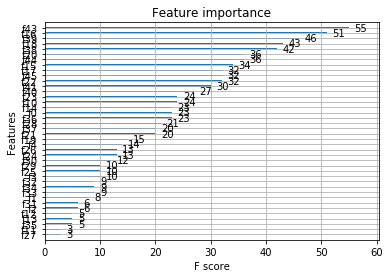

In [34]:
# plot the feature importances
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model)
plt.show()

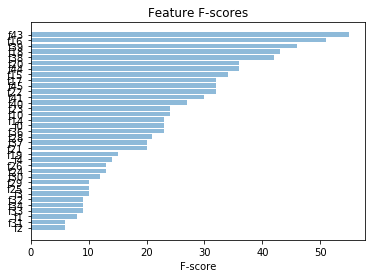

40 features reduced to 35


In [35]:
# get the feature importance scores
weight_score = xgb_model.get_score(importance_type='weight')
gain_score = xgb_model.get_score(importance_type='gain')
cover_score = xgb_model.get_score(importance_type='cover')
f_score = xgb_model.get_fscore()

import operator 
thresh = 0.10 # minimum % contribution of F-score
max_fscore = np.max(list(f_score.values()))
significant_features = [k for (k, v) in sorted(f_score.items(), key=operator.itemgetter(1)) if v > thresh*max_fscore]

signif_scores = [f_score[k] for k in significant_features]
ypos = np.arange(len(signif_scores)) # y position
plt.barh(ypos, signif_scores, align='center', alpha=0.5)
plt.yticks(ypos, significant_features)
plt.xlabel('F-score')
plt.title('Feature F-scores')
plt.show()

print("{} features reduced to {}".format(len(f_score), len(significant_features)))

### Hyperparameter tuning

In [37]:
search_results = {}
for depth in range(3, 9):
    params =  params = {'objective': 'rank:pairwise',
              'silent': 0,
              'eval_metric': ['ndcg@5','ndcg'],
              'min_child_weight': 5,
              'learning_rate': 0.1,
              'max_depth': depth,
              'gamma': 0.25,
              'subsample': 1.0,
              'colsample_bytree': 0.8
              }

    # early-stopping will evaluate again both test and train
    search_results[depth] = xgb.cv(params, Dtrain, num_boost_round=2500, early_stopping_rounds=10, nfold=5)

print("Tuning depth")
scores = {}
for t, res in sorted(search_results.items()):
    print(t, res)
    # results will be one row per boosting iteration
    scores[t] = res['test-ndcg-mean'].max()
    
best_depth = max(scores.items(), key=operator.itemgetter(1))[0]

XGBoostError: [15:47:10] src/c_api/c_api.cc:685: Check failed: src.info.group_ptr_.size() == 0U (472 vs. 0) : slice does not support group structure
Stack trace:

